**Adapted from** https://github.com/pierrexyz/pybird/blob/master/notebooks/correlator.ipynb

**To install Pybird: run these three lines in your terminal**

git clone https://github.com/pierrexyz/pybird.git

cd pybird

pip install .

**To install the PyBird likelihood, read the explanation here :**

https://github.com/pierrexyz/pybird

In [1]:
import os, sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from classy import Class

In [2]:
font = {'size': 14}
axislabelfontsize='large'
matplotlib.rc('font', **font)

# The PyBird Correlator Class

**PyBird** computes EFT predictions for correlators of density fields: in real space or redshift space (multipoles), of dark matter or biased tracers, in Fourier (power spectrum) or configuration space (correlation function).  
What and how we want **PyBird** to perform such computation is communicated through the `Correlator()` class.  

In [3]:
from pybird.correlator import Correlator

### Setting the linear cosmology

Redshift?

In [4]:
z = 0.57

First, we create a **CLASS** Engine `M`, that will be provided to the **PyBird** Correlator Engine. 

In [5]:
M = Class()
cosmo = {'omega_b': 0.02235, 'omega_cdm': 0.120, 'h': 0.675, 'ln10^{10}A_s': 3.044, 'n_s': 0.965}
M.set(cosmo)
M.set({'output': 'mPk', 'P_k_max_h/Mpc': 1, 'z_max_pk': z})
M.compute()

In [6]:
kk = np.logspace(-5, 0, 200)
pk_lin = np.array([M.pk_lin(k*M.h(), z)*M.h()**3 for k in kk]) 

In [7]:
D1, f1 = M.scale_independent_growth_factor(z), M.scale_independent_growth_factor_f(z)

All what **PyBird** needs is a linear cosmology, e.g., a linear power spectrum `pklin` and the $k$-array on which it is provided, `kk`.  
In redshift space, we will also need to provide the growth rate `f1`. 

That's all. 

Oh, and let us specify a $k$-array (or $s$-array for configuration space) on which we want to have the EFT prediction evaluated. 

In [8]:
dk, ds = 0.01, 5
kd = np.arange(0.005, 0.3, dk)
sd = np.arange(10, 200, ds)

### Setting the Pybird Correlator class

We create a **PyBird** Correlator Engine `N`.

In [9]:
N = Correlator()

Next, we specify what we want to PyBird to compute for us.  

We can see what can be specified with the following command. 

In [10]:
N.info()



Configuration commands [.set(config_dict)]
----------------------
'output': ['str'] ; options: ['bPk', 'bCf', 'mPk', 'mCf', 'bmPk', 'bmCf']
    - Correlator: biased tracers / matter / biased tracers-matter -- power spectrum / correlation function.
    * default: bPk
'multipole': ['int'] ; options: [0, 2, 3]
    - Number of multipoles. 0: real space. 2: monopole + quadrupole. 3: monopole + quadrupole + hexadecapole.
    * default: 2
'z': ['float']
    - Effective redshift.
    * default: None
'km': ['float']
    - Inverse tracer spatial extension scale in [h/Mpc].
    * default: 0.7
'kr': ['float']
    - Inverse velocity product renormalization scale in [h/Mpc].
    * default: 0.25
'nd': ['float']
    - Mean galaxy density
    * default: 0.0003
'kmax': ['float']
    - kmax in [h/Mpc] for 'output': '_Pk'
    * default: 0.25
'with_bias': ['bool']
    - Bias (in)dependent evalution. Automatically set to False for 'with_time': False.
    * default: False
'eft_basis': ['str']
    - Basis o

#### Dark matter in real space

Let us start with dark matter in real space. 

In [11]:
N.set({'output': 'mPk', 'multipole': 0, 'kmax': 0.3, 'xdata': kd, 'with_bias': True}) 

The first time we ask **PyBird** to do a specific computation, it will generate loop matrices according the FFTLog of the linear power spectrum, see e.g., App. A of [2110.07539](https://arxiv.org/abs/2110.07539) , and save them.  
The next time, it will simply load the matrices, and the call to this computation setup will be much faster. 

Now let **PyBird** compute. 

In [12]:
N.compute({'kk': kk, 'pk_lin': pk_lin, 'bias': {'cct': -1}})

We can now get the matter power spectrum: 

In [13]:
mPk = N.get()

In [14]:
N2 = Correlator()
N2.set({'output': 'mPk', 'multipole': 0, 'kmax': 0.3, 'xdata': kd, 'with_bias': True})
N2.compute({'kk': kk, 'pk_lin': pk_lin, 'bias': {'cct': 0}})
mPk_SPT = N2.get()

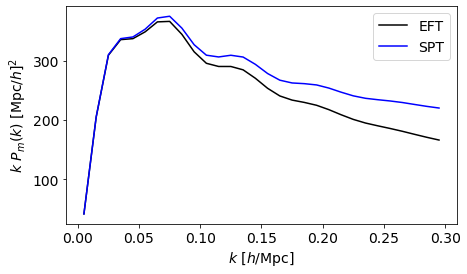

In [15]:
plt.figure(figsize=(7,4))
plt.plot(kd, kd * mPk[0], 'k', label='EFT')
plt.plot(kd, kd * mPk_SPT[0], 'blue', label='SPT')
plt.xlabel(r'$k \ [h/{\rm Mpc}]$')
plt.ylabel(r'$k \ P_m(k) \ [{\rm Mpc}/h]^2$')
plt.legend()
plt.show()

As you may have noticed, communicating with **PyBird** Correlator Engine is very similar to the **CLASS** Engine. 

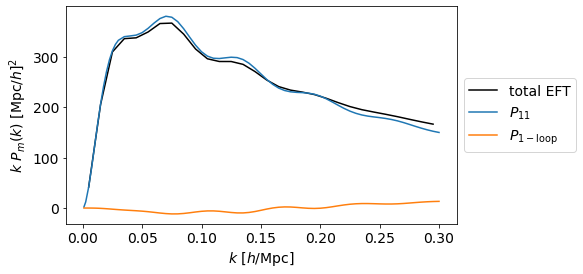

In [16]:
kdata= N.co.k

plt.figure(figsize=(7,4))
plt.plot(kd, kd * mPk[0], 'k', label='total EFT')
plt.plot(kdata, kdata * N.bird.P11, label='$P_{11}$')
plt.plot(kdata, kdata * N.bird.Ps[1][0], label=r'$P_{\rm 1-loop}$')
plt.xlabel(r'$k \ [h/{\rm Mpc}]$')
plt.ylabel(r'$k \ P_m(k) \ [{\rm Mpc}/h]^2$')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#### Biased tracers in redshift space

Let us now turn to biased tracers in redshift space.

We load some fiducial EFT parameters from a previous fit. 

In [17]:
outdir = os.path.join(os.path.expanduser('~'), 'Documents', 'Codes', 'pybird', 'data', 'eftboss', 'out')
with open(os.path.join(outdir, 'fit_boss_onesky_pk_wc_cmass_ngc_l0.dat')) as f: data_file = f.read()
eft_params_str = data_file.split(', \n')[1].replace("# ", "")
eft_params = {key: float(value) for key, value in (pair.split(': ') for pair in eft_params_str.split(', '))}
print (eft_params)

{'b1': 1.9542, 'c2': 0.5904, 'c4': 0.0, 'b3': -0.3687, 'cct': 0.1825, 'cr1': -0.8476, 'cr2': -0.8134, 'ce0': 1.4985, 'ce1': 0.0, 'ce2': -1.6364, 'b2': 0.4175, 'b4': 0.4175}


Now let us make the **PyBird** Correlator Engine compute: 

In [18]:
N = Correlator()

N.set({'output': 'bPk', 'multipole': 3, 'kmax': 0.3, 'xdata': kd, 
       'km': 0.7, 'kr': 0.35, 'nd': 3e-4,           # these scales control the various EFT expansions...
       'eft_basis': 'eftoflss', 'with_stoch': True, # there are various equivalent EFT parametrization one can choose
       'with_bias': True}) 

N.compute({'kk': kk, 'pk_lin': pk_lin, 'f': f1, # here we also pass the growth rate f since we are now in redshift space
           'bias': eft_params}) 

bPk = N.get()

The scales controlling the various EFT expansions are well described in [2210.14931](https://arxiv.org/abs/2210.14931) (see also [2110.00016](https://arxiv.org/abs/2110.00016)).

There are various equivalent basis for the EFT parameters that are implemented in **PyBird** (see `Correlator.info()`).  
Those are described in e.g., [2208.05929](https://arxiv.org/abs/2208.05929).  
For each basis, you can find the EFT parameter names recognized by **PyBird** in https://github.com/pierrexyz/pybird/tree/v1.1/data/eftboss/config

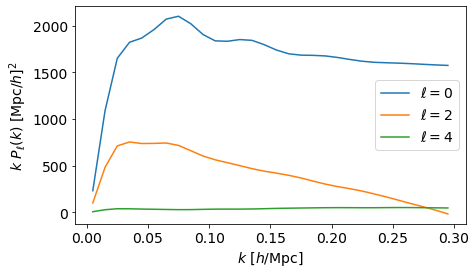

In [19]:
plt.figure(figsize=(7,4))
for i in range(3): plt.errorbar(kd, kd * bPk[i], label=r'$\ell=%s$' % (2*i))
plt.xlabel(r'$k \ [h/{\rm Mpc}]$')
plt.ylabel(r'$k \ P_\ell(k) \ [{\rm Mpc}/h]^2$')
plt.legend()
plt.show()

#### Configuration space

Finally, let us compute the multipoles of the correlation function of biased tracers. 

In [20]:
N = Correlator()

N.set({'output': 'bCf', 'multipole': 3, 'kmax': 0.3, 'xdata': sd, 'km': 0.7, 'kr': 0.35,
       'eft_basis': 'eftoflss'})          # there is no stochastic term in configuration space, see 2110.07539

N.compute({'kk': kk, 'pk_lin': pk_lin, 'f': f1, 'bias': eft_params}) 

bCf = N.get()

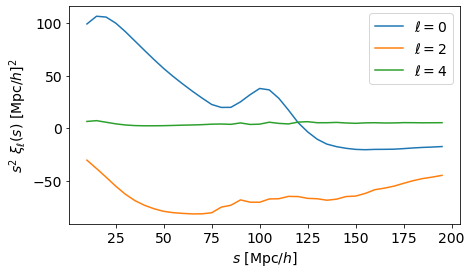

In [21]:
plt.figure(figsize=(7,4))
for i in range(3): plt.errorbar(sd, sd**2 * bCf[i], label=r'$\ell=%s$' % (2*i))
plt.xlabel(r'$s \ [{\rm Mpc}/h]$')
plt.ylabel(r'$s^2 \ \xi_\ell(s) \ [{\rm Mpc}/h]^2$')
plt.legend()
plt.show()